# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

## Perform standard imports and load datasets

In [11]:
import pandas as pd
import numpy as np

# Load specific forecasting tools
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv('./DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv('./TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [2]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

___
## Autoregressive Moving Average - ARMA(p,q)
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.
### Plot the source data

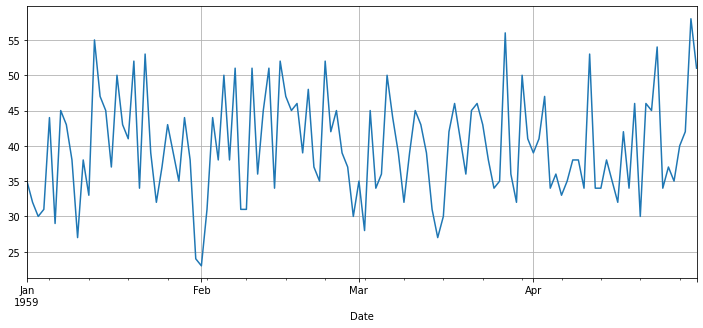

In [3]:
df1['Births'].plot(figsize=(12,5), grid=True);

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [4]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Determine the (p,q) ARMA Orders using <tt>pmdarima.auto_arima</tt>
This tool should give just $p$ and $q$ value recommendations for this dataset.

In [14]:
auto_arima(df1['Births'],seasonal=False)

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [7]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]

### Fit an ARMA(p,q) Model

In [12]:
model = ARIMA(train['Births'],order=(2,0,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -307.812
Date:                Fri, 25 Nov 2022   AIC                            627.625
Time:                        21:18:45   BIC                            642.624
Sample:                    01-01-1959   HQIC                           633.673
                         - 03-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7578      1.017     39.095      0.000      37.765      41.751
ar.L1         -0.4667      1.005     -0.464      0.642      -2.437       1.503
ar.L2          0.5073      0.942      0.539      0.590      -1.339       2.353
ma.L1          0.5626      4.160      0.135      0.892      -7.592       8.717
ma.L2         -0.4370      1.891     -0.231      0.817      -4.144       3.270
sigma2        54.3913    204.723      0.266      0.790    -346.858     455.640
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.96   Prob(JB):                         0.37
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Obtain a month's worth of predicted values

In [15]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

### Plot predictions against known values

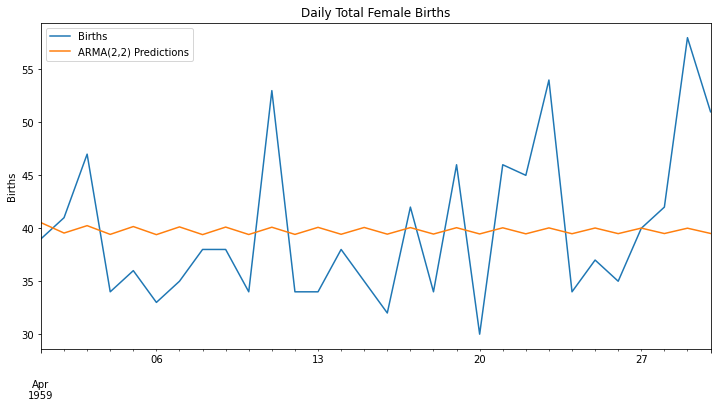

In [16]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.

___
## Autoregressive Integrated Moving Average - ARIMA(p,d,q)
The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.<br>
First let's take a look at the <em>Real Manufacturing and Trade Inventories</em> dataset.
### Plot the Source Data

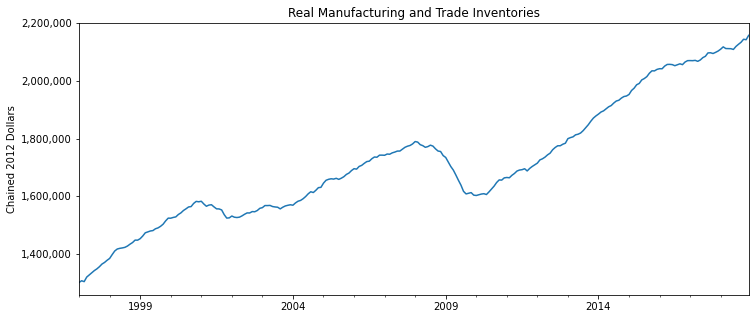

In [17]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Run an ETS Decomposition (optional)
We probably won't learn a lot from it, but it never hurts to run an ETS Decomposition plot.

<Figure size 864x864 with 0 Axes>

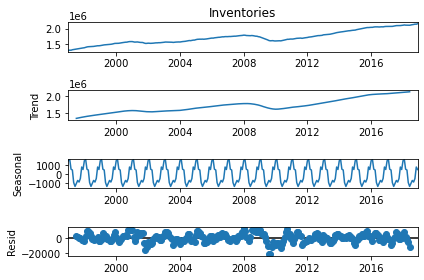

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

Here we see that the seasonal component does not contribute significantly to the behavior of the series.
### Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [23]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Fri, 25 Nov 2022   AIC                           5348.037
Time:                        21:22:52   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This suggests that we should fit an ARIMA(1,1,1) model to best forecast future values of the series. Before we train the model, let's look at augmented Dickey-Fuller Test, and the ACF/PACF plots to see if they agree. These steps are optional, and we would likely skip them in practice.

### Run the augmented Dickey-Fuller Test on the First Difference

In [24]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference.
### Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

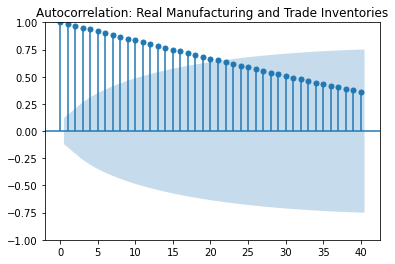

In [25]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

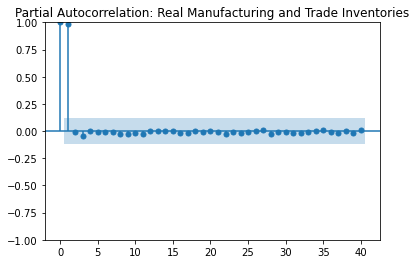

In [26]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [27]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.358 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Fri, 25 Nov 2022   AIC                           5348.037
Time:                        21:23:58   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks good from here! Now let's train & test the ARIMA(1,1,1) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

In [28]:
len(df2)

264

In [29]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

### Fit an ARIMA(1,1,1) Model

In [30]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2557.774
Date:                Fri, 25 Nov 2022   AIC                           5121.548
Time:                        21:24:18   BIC                           5132.124
Sample:                    01-01-1997   HQIC                          5125.804
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    845.307      0.000       0.998       1.002
ma.L1         -0.9999      0.034    -29.254      0.000      -1.067      -0.933
sigma2      2.956e+07   3.55e-10   8.32e+16      0.000    2.96e+07    2.96e+07
===================================================================================
Ljung-Box (L1) (Q):                  87.24   Jarque-Bera (JB):               101.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -1.18
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+32. Standard errors may be unstable.
"""

In [31]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [32]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2106362.022, expected=2110158
predicted=2108973.041, expected=2118199
predicted=2111584.058, expected=2112427
predicted=2114195.071, expected=2112276
predicted=2116806.081, expected=2111835
predicted=2119417.089, expected=2109298
predicted=2122028.094, expected=2119618
predicted=2124639.095, expected=2127170
predicted=2127250.094, expected=2134172
predicted=2129861.09 , expected=2144639
predicted=2132472.083, expected=2143001
predicted=2135083.073, expected=2158115


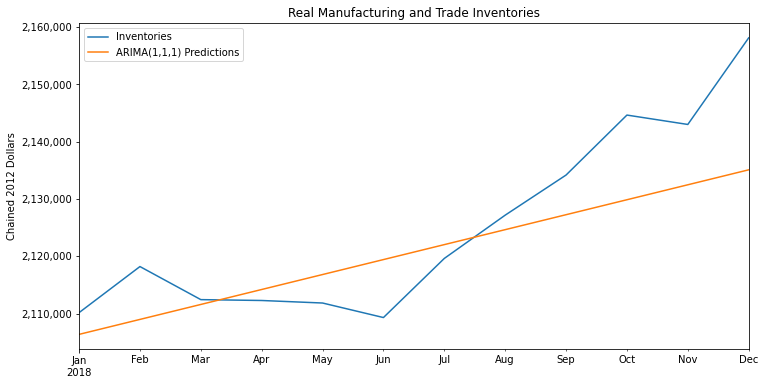

In [33]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### Evaluate the Model

In [34]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 95905828.38


In [35]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 9793.152117


### Retrain the model on the full data, and forecast the future

In [36]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

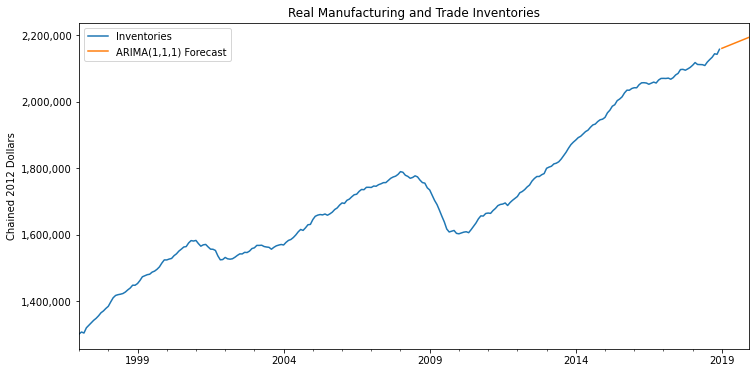

In [37]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);